In [1]:
project_structure = """
nlp_sentiment_classifier/
├── data/                  # Raw and/or cleaned datasets
├── notebooks/             # Jupyter notebooks for EDA and experimentation
├── scripts/               # Run scripts and pipelines
│   ├── train.py           # Training entry point (modular + clean)
│   └── evaluate.py        # Evaluation, metrics, visualization
├── src/                   # Core logic & reusable modules
│   ├── preprocessing.py   # Text cleaning, tokenization, etc.
│   ├── models.py           # Model building, training, saving
│   ├── utils.py           # Helper functions
├── app/                   # API or deployment app (e.g., FastAPI)
│   └── main.py            # API routes, prediction endpoint
├── requirements.txt       # Project dependencies
├── README.md              # Project overview, instructions, etc.
"""
print(project_structure)



nlp_sentiment_classifier/
├── data/                  # Raw and/or cleaned datasets
├── notebooks/             # Jupyter notebooks for EDA and experimentation
├── scripts/               # Run scripts and pipelines
│   ├── train.py           # Training entry point (modular + clean)
│   └── evaluate.py        # Evaluation, metrics, visualization
├── src/                   # Core logic & reusable modules
│   ├── preprocessing.py   # Text cleaning, tokenization, etc.
│   ├── model.py           # Model building, training, saving
│   ├── utils.py           # Helper functions
├── app/                   # API or deployment app (e.g., FastAPI)
│   └── main.py            # API routes, prediction endpoint
├── requirements.txt       # Project dependencies
├── README.md              # Project overview, instructions, etc.



# import libraries

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import string

# Load the data

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("julian3833/jigsaw-toxic-comment-classification-challenge")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/jigsaw-toxic-comment-classification-challenge


In [4]:
train_df = pd.read_csv(f"{path}/train.csv")
test_df = pd.read_csv(f"{path}/test.csv")
test_labels_df = pd.read_csv(f"{path}/test_labels.csv")


In [5]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Test labels shape:", test_labels_df.shape)




Train shape: (159571, 8)
Test shape: (153164, 2)
Test labels shape: (153164, 7)


# EDA

## information about the data


In [6]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
train_df.duplicated().sum()

np.int64(0)

In [8]:
train_df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
train_df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [10]:
train_df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


## Label Distribution

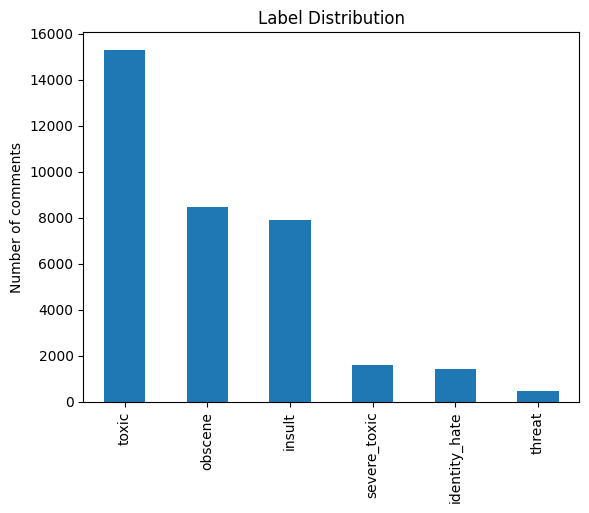

In [11]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_df[label_cols].sum().sort_values(ascending=False).plot(
    kind="bar", title="Label Distribution"
)
plt.ylabel("Number of comments")

plt.show()


##  How Many Multi-labels?


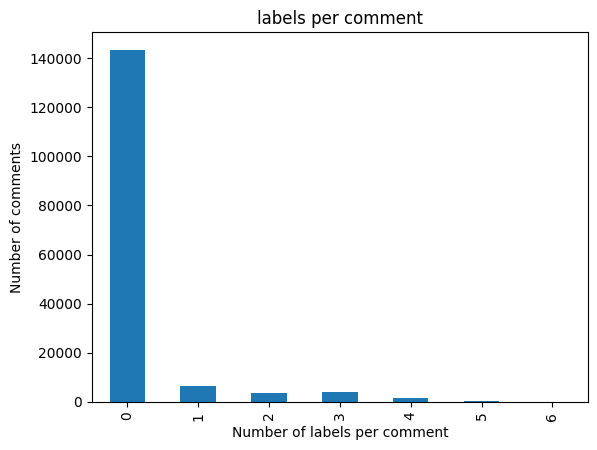

In [12]:
train_df["label_count"] = train_df[label_cols].sum(axis=1)

train_df["label_count"].value_counts().sort_index().plot(
    kind="bar",
    title="labels per comment"
)
plt.xlabel("Number of labels per comment")
plt.ylabel("Number of comments")
plt.show()


## Sample

In [13]:
train_df[train_df['toxic']==1].sample(1)['comment_text'].values

array(["And whats the point of editing a file if your gonna freakin' change it back Wikipedia, takeoff the editing if your gonna place that false crap back. You don't know nothing, Serbs had less casualties up to 45 then, not 450, you kidding. I swear you are a terrible editor, your false! Serbia got less casualties because the KLA is weak!"],
      dtype=object)

## Comment Length Distribution

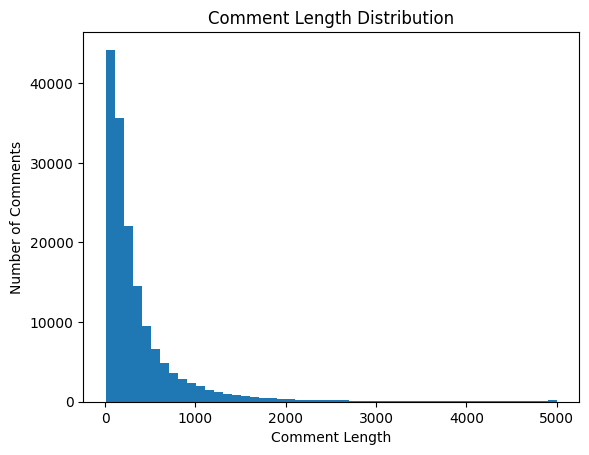

In [14]:
train_df['comment_length'] = train_df['comment_text'].apply(len)
train_df['comment_length'].plot(kind='hist', bins=50, title='Comment Length Distribution')
plt.xlabel('Comment Length')
plt.ylabel('Number of Comments')
plt.show()

## WordClouds

In [15]:
from wordcloud import WordCloud

toxic_text = " ".join(train_df[train_df["toxic"]==1]["comment_text"])
clean_text = " ".join(train_df[train_df[label_cols].sum(axis=1)==0]["comment_text"])

wordcloud_toxic = WordCloud(width=800, height=400).generate(toxic_text)
wordcloud_clean = WordCloud(width=800, height=400).generate(clean_text)



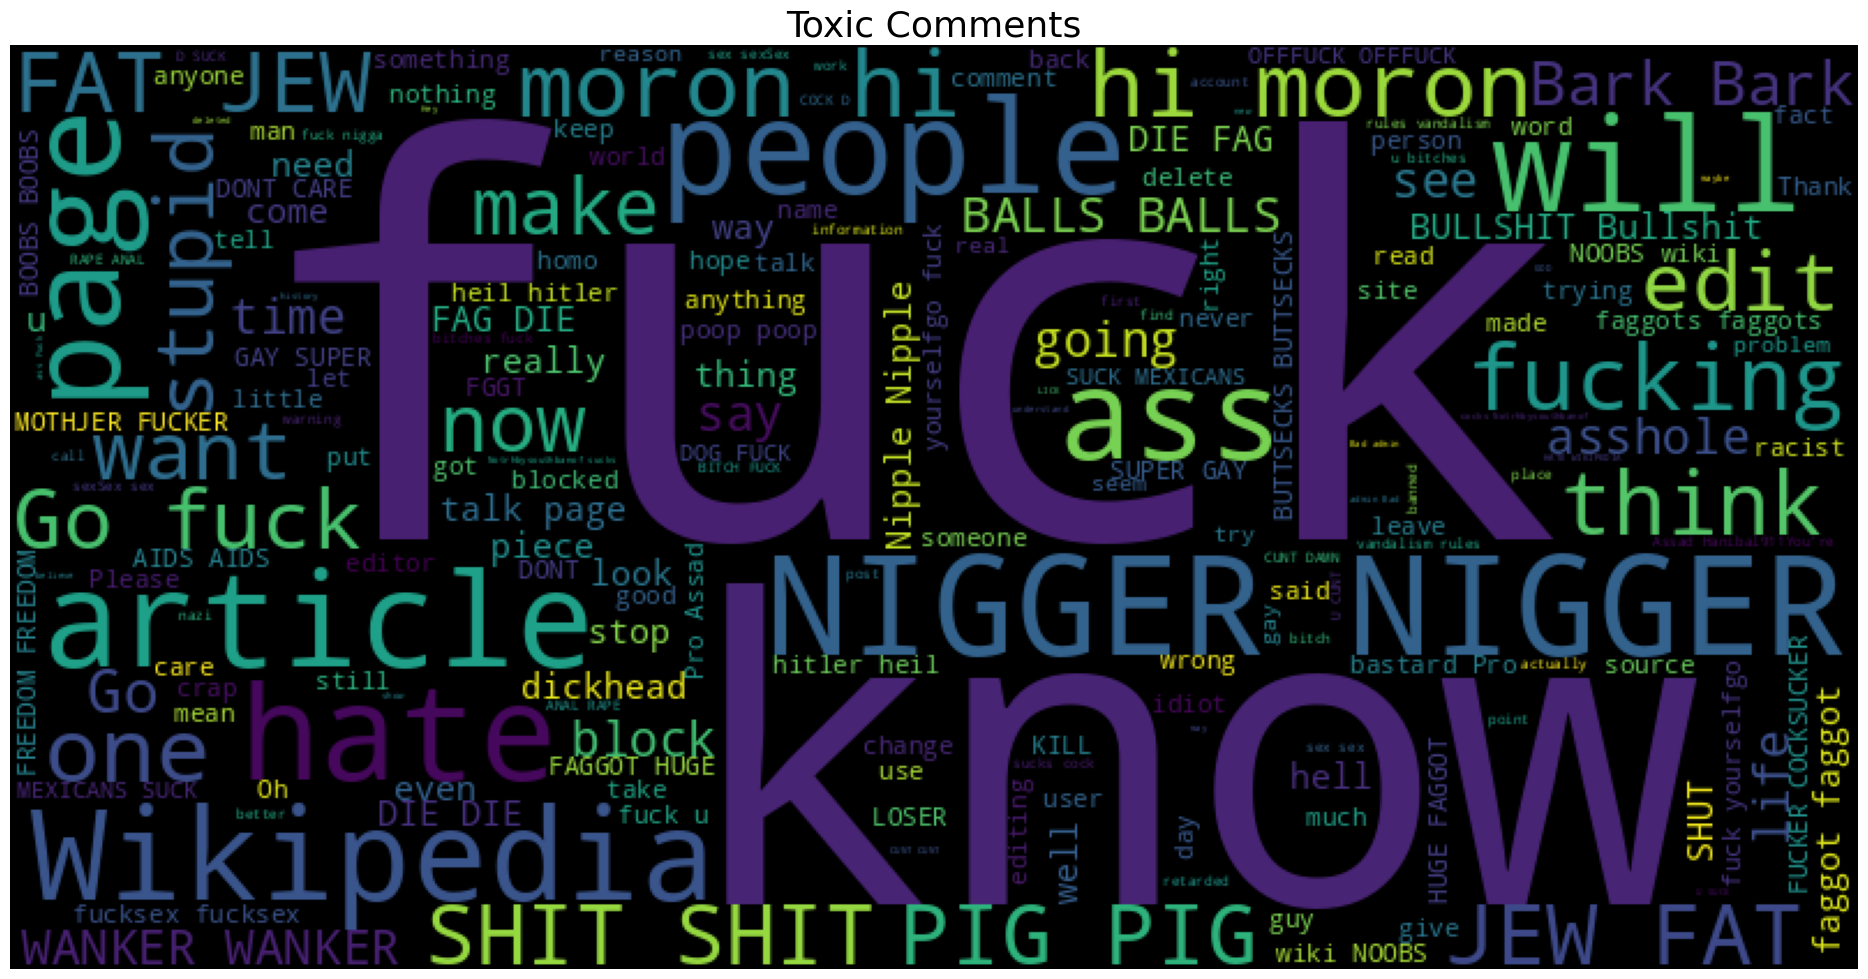

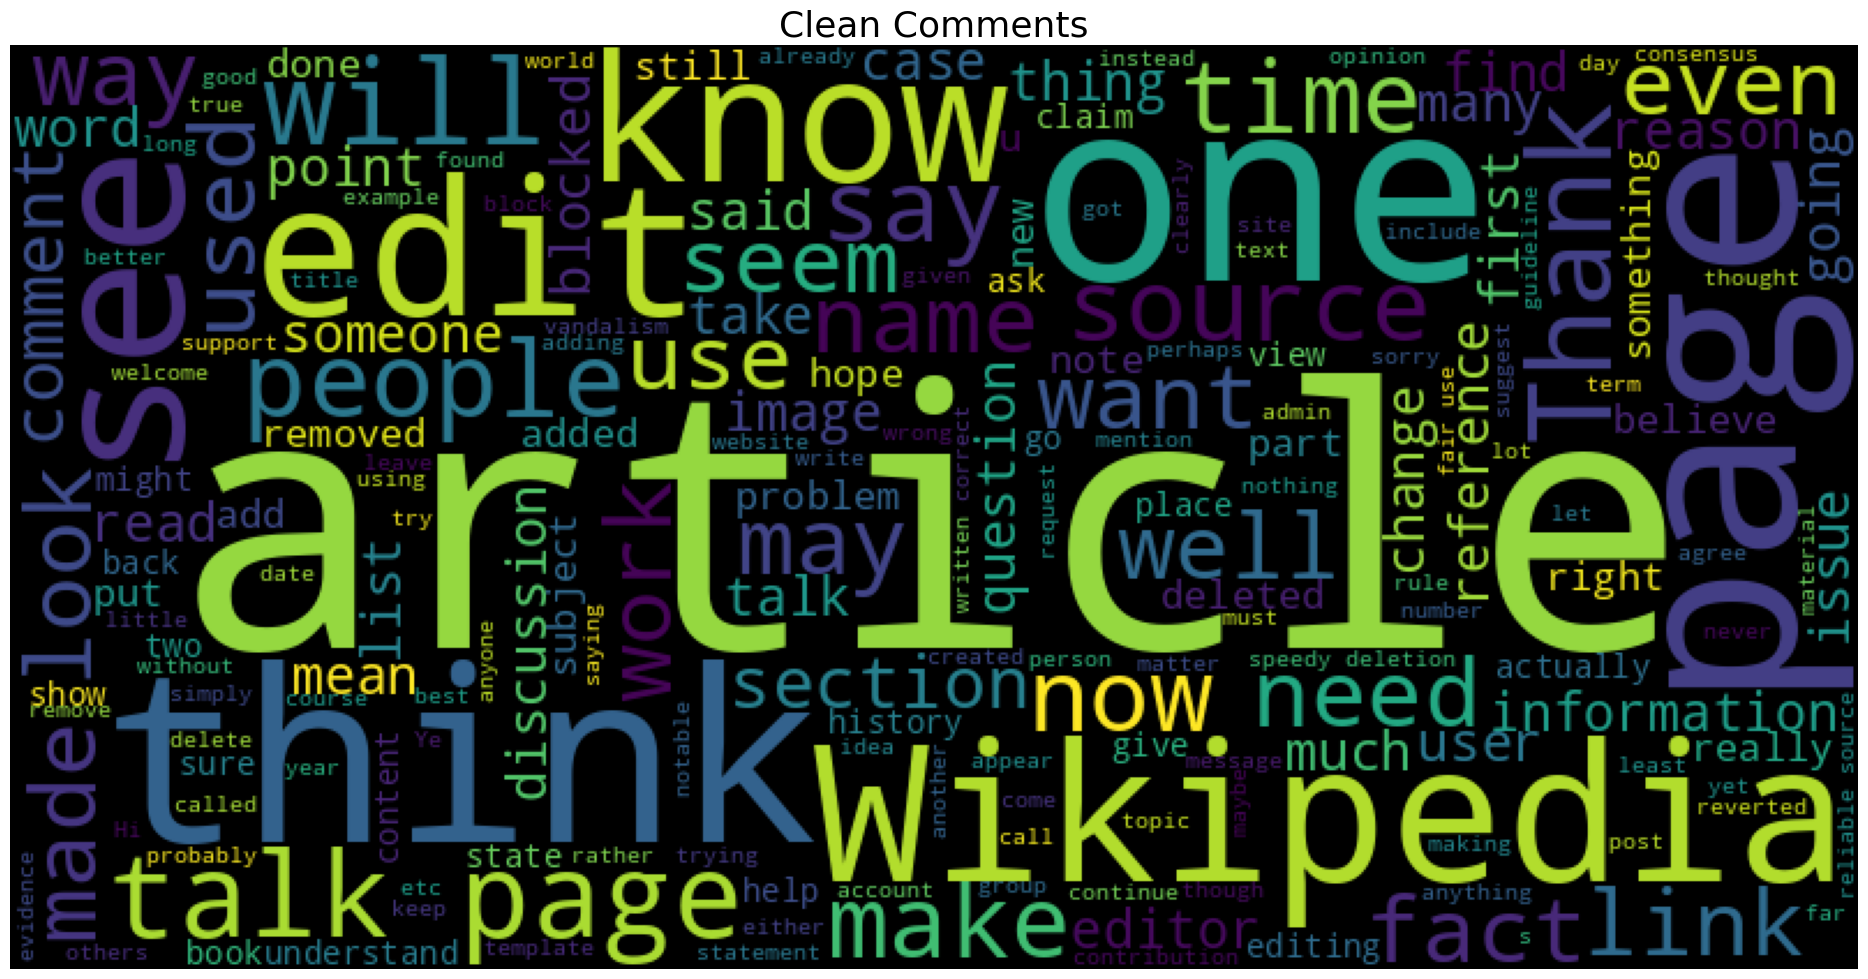

In [16]:
plt.figure(figsize=(26, 12))
plt.imshow(wordcloud_toxic)
plt.axis("off")
plt.title("Toxic Comments", fontsize=26)

plt.figure(figsize=(26, 12))
plt.imshow(wordcloud_clean)
plt.axis("off")
plt.title("Clean Comments",fontsize=26)
plt.show()

## Top Words per Label

In [17]:
for label in label_cols:
    texts = train_df[train_df[label] == 1]['comment_text']
    vec = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=20)
    bag = vec.fit_transform(texts)
    print(f"Top words for label '{label}':")
    print(vec.get_feature_names_out())
    print('------------------------------------')

Top words for label 'toxic':
['ass' 'die' 'don' 'faggot' 'fat' 'fuck' 'fuck fuck' 'fucking' 'gay'
 'hate' 'just' 'know' 'like' 'nigger' 'nigger nigger' 'page' 'people'
 'shit' 'suck' 'wikipedia']
------------------------------------
Top words for label 'severe_toxic':
['ass' 'ass ass' 'bitch' 'cock' 'cunt' 'die' 'die die' 'faggot'
 'faggot faggot' 'fuck' 'fuck fuck' 'fucking' 'fucksex' 'nigger' 'shit'
 'shit shit' 'suck' 'suck suck' 'sucks' 'wikipedia']
------------------------------------
Top words for label 'obscene':
['ass' 'bitch' 'cunt' 'dick' 'die' 'don' 'faggot' 'fat' 'fuck' 'fuck fuck'
 'fucking' 'just' 'know' 'like' 'nigger' 'nigger nigger' 'shit'
 'shit shit' 'suck' 'wikipedia']
------------------------------------
Top words for label 'threat':
['ass' 'ass ass' 'ban' 'block' 'die' 'die die' 'die jim' 'don' 'fuck'
 'fucking' 'going' 'jim' 'jim wales' 'kill' 'kill kill' 'page'
 'supertr0ll' 'wales' 'wales die' 'wikipedia']
------------------------------------
Top words for labe

## check whether a feature or problem exists before cleaning it.

In [18]:
train_df['has_url'] = train_df['comment_text'].str.contains(r"http|www", regex=True)
print(train_df['has_url'].mean())  # percentage of comments with URLs


0.032393104010127155


In [19]:
train_df['has_html'] = train_df['comment_text'].str.contains(r'<.*?>', regex=True)
train_df['has_html'].mean()


np.float64(0.0008084175696085128)

In [20]:
train_df['has_mention'] = train_df['comment_text'].str.contains(r'@\w+', regex=True)
train_df['has_mention'].mean()


np.float64(0.00449956445720087)

In [21]:
train_df['has_digits'] = train_df['comment_text'].str.contains(r'\d+', regex=True)
train_df['has_digits'].mean()


np.float64(0.3209355083317144)

<Axes: >

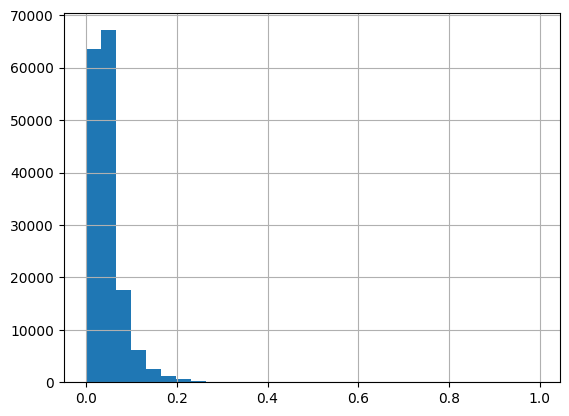

In [26]:
train_df['punctuation_ratio'] = train_df['comment_text'].apply(lambda x: sum(1 for c in x if c in string.punctuation) / len(x))
train_df['punctuation_ratio'].hist(bins=30)


## check correlation

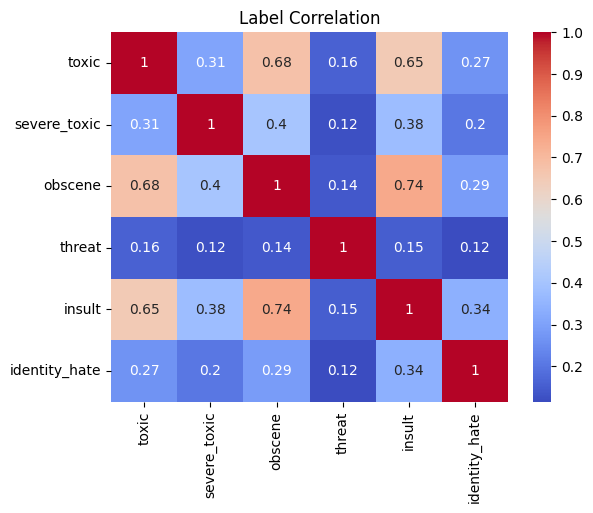

In [27]:
sns.heatmap(train_df[label_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Label Correlation")
plt.show()

## empty or long comments

In [28]:
train_df[train_df['comment_length'] == 0].shape  # Empty after cleaning?


(0, 15)

In [29]:
train_df[train_df['comment_length'] > 1000].shape  # Outliers


(13360, 15)

## Check for slang

In [30]:
slang_list = [
    # Common short/informal speech
    "u", "ur", "r", "ya", "gonna", "wanna", "gotta", "lemme", "kinda", "ain’t", "y'all", "nah", "thx", "pls", "plz",

    # Emotions / reactions
    "lol", "lmao", "rofl", "omg", "wtf", "smh", "tbh", "idk", "ikr", "bruh", "af", "fml", "ffs",

    # Toxic / hateful shorthand
    "fu", "kys", "stfu", "bitch", "biatch", "fck", "f*ck", "f---", "a**hole", "d*ck", "nigga", "n1gga", "ni99a", "retard", "r3tard", "re**rd", "sucka",

    # Abbreviated or obfuscated hate
    "h8", "h8r", "killurself", "go2hell", "gtfo", "gtf", "die", "kys", "idiot", "moron", "loser",

    # Mocking or sarcastic text
    "lulz", "noob", "n00b", "scrub", "simp", "trash", "cringe",

    # Often used in threats
    "bomb", "shoot", "stab", "burn", "rape"
]


In [31]:
def contains_slang(text, slang_words):
    words = text.lower().split()
    return any(word in slang_words for word in words)


In [32]:
train_df['has_slang'] = train_df['comment_text'].apply(lambda x: contains_slang(x, slang_list))

In [33]:
train_df['has_slang'].mean()


np.float64(0.037356411879351514)

In [34]:
train_df[train_df['has_slang']].sample(1)['comment_text']


,comment_text
120303,DrPrinceton\n\nhttps://en.wikipedia.org/wiki/8...
